<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [99]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [100]:
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [101]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [102]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Review ID                1000 non-null   int64 
 1   Clothing ID              1000 non-null   int64 
 2   Age                      1000 non-null   int64 
 3   Title                    810 non-null    object
 4   Review Text              958 non-null    object
 5   Rating                   1000 non-null   int64 
 6   Recommended IND          1000 non-null   int64 
 7   Positive Feedback Count  1000 non-null   int64 
 8   Division Name            1000 non-null   object
 9   Department Name          1000 non-null   object
 10  Class Name               1000 non-null   object
dtypes: int64(6), object(5)
memory usage: 86.1+ KB


In [103]:
# Droping N/A records
reviews = reviews.dropna(subset=["Review Text"])


In [104]:
from sentence_transformers import SentenceTransformer

# Load a model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create list of embeddings
review_list = reviews["Review Text"].tolist()
embeddings_array = model.encode(review_list, convert_to_numpy=True)
embeddings = embeddings_array.tolist()

In [105]:
from sklearn.manifold import TSNE

# Reducing dimensionality
tsne = TSNE(
    n_components=2,     # reduce to 2D
    perplexity=30,      
    random_state=42
)

embeddings_2d = tsne.fit_transform(embeddings_array)

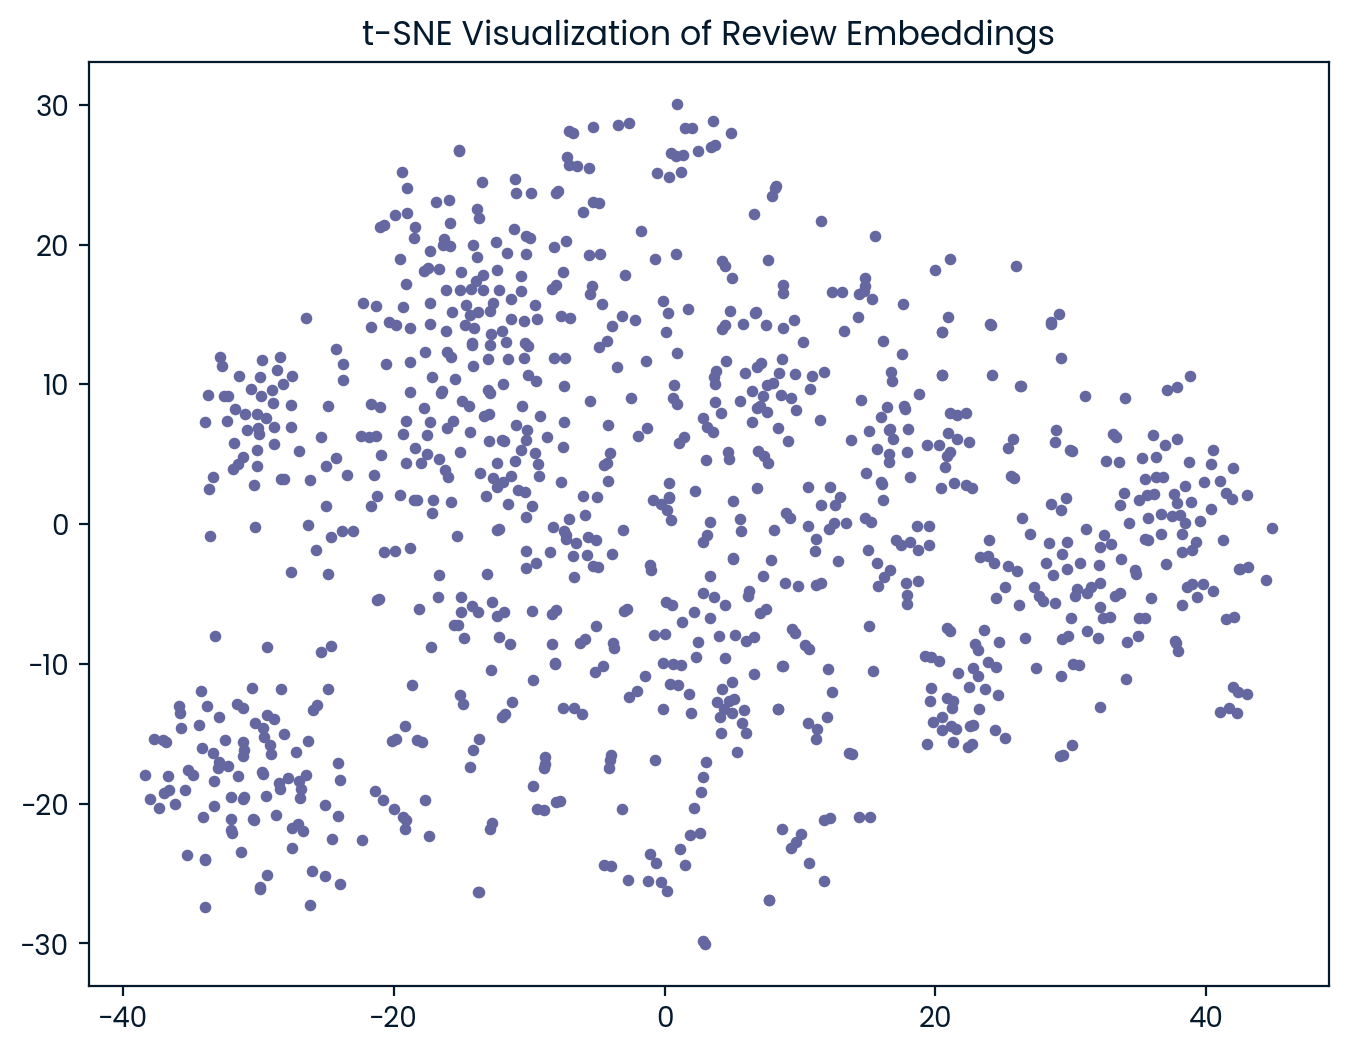

In [106]:
# Visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], s=10)
plt.title("t-SNE Visualization of Review Embeddings")
plt.show()


In [107]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Feedback categorization
topics = [
    "issues related to fabric quality or stitching",
    "opinion about comfort or feel while wearing",
    "comments with sizing or the fit of the garment",
    "complaints about price or value for money",
    "issues with late or wrong delivery",
    "how pretty object is and overall aspect"
]

topic_embeddings = model.encode(topics, convert_to_numpy=True)
similarity_matrix = cosine_similarity(embeddings_array, topic_embeddings)

# Assign topic to each review
review_top_topics = np.argmax(similarity_matrix, axis=1)

assigned_topics = [topics[i] for i in review_top_topics]

In [108]:
# Transform topics with the same t-SNE model
combined = np.vstack([embeddings_array, topic_embeddings])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_2d = tsne.fit_transform(combined)

# split back
embeddings_2d = combined_2d[:len(embeddings)]
topic_embeddings_2d = combined_2d[len(embeddings):]

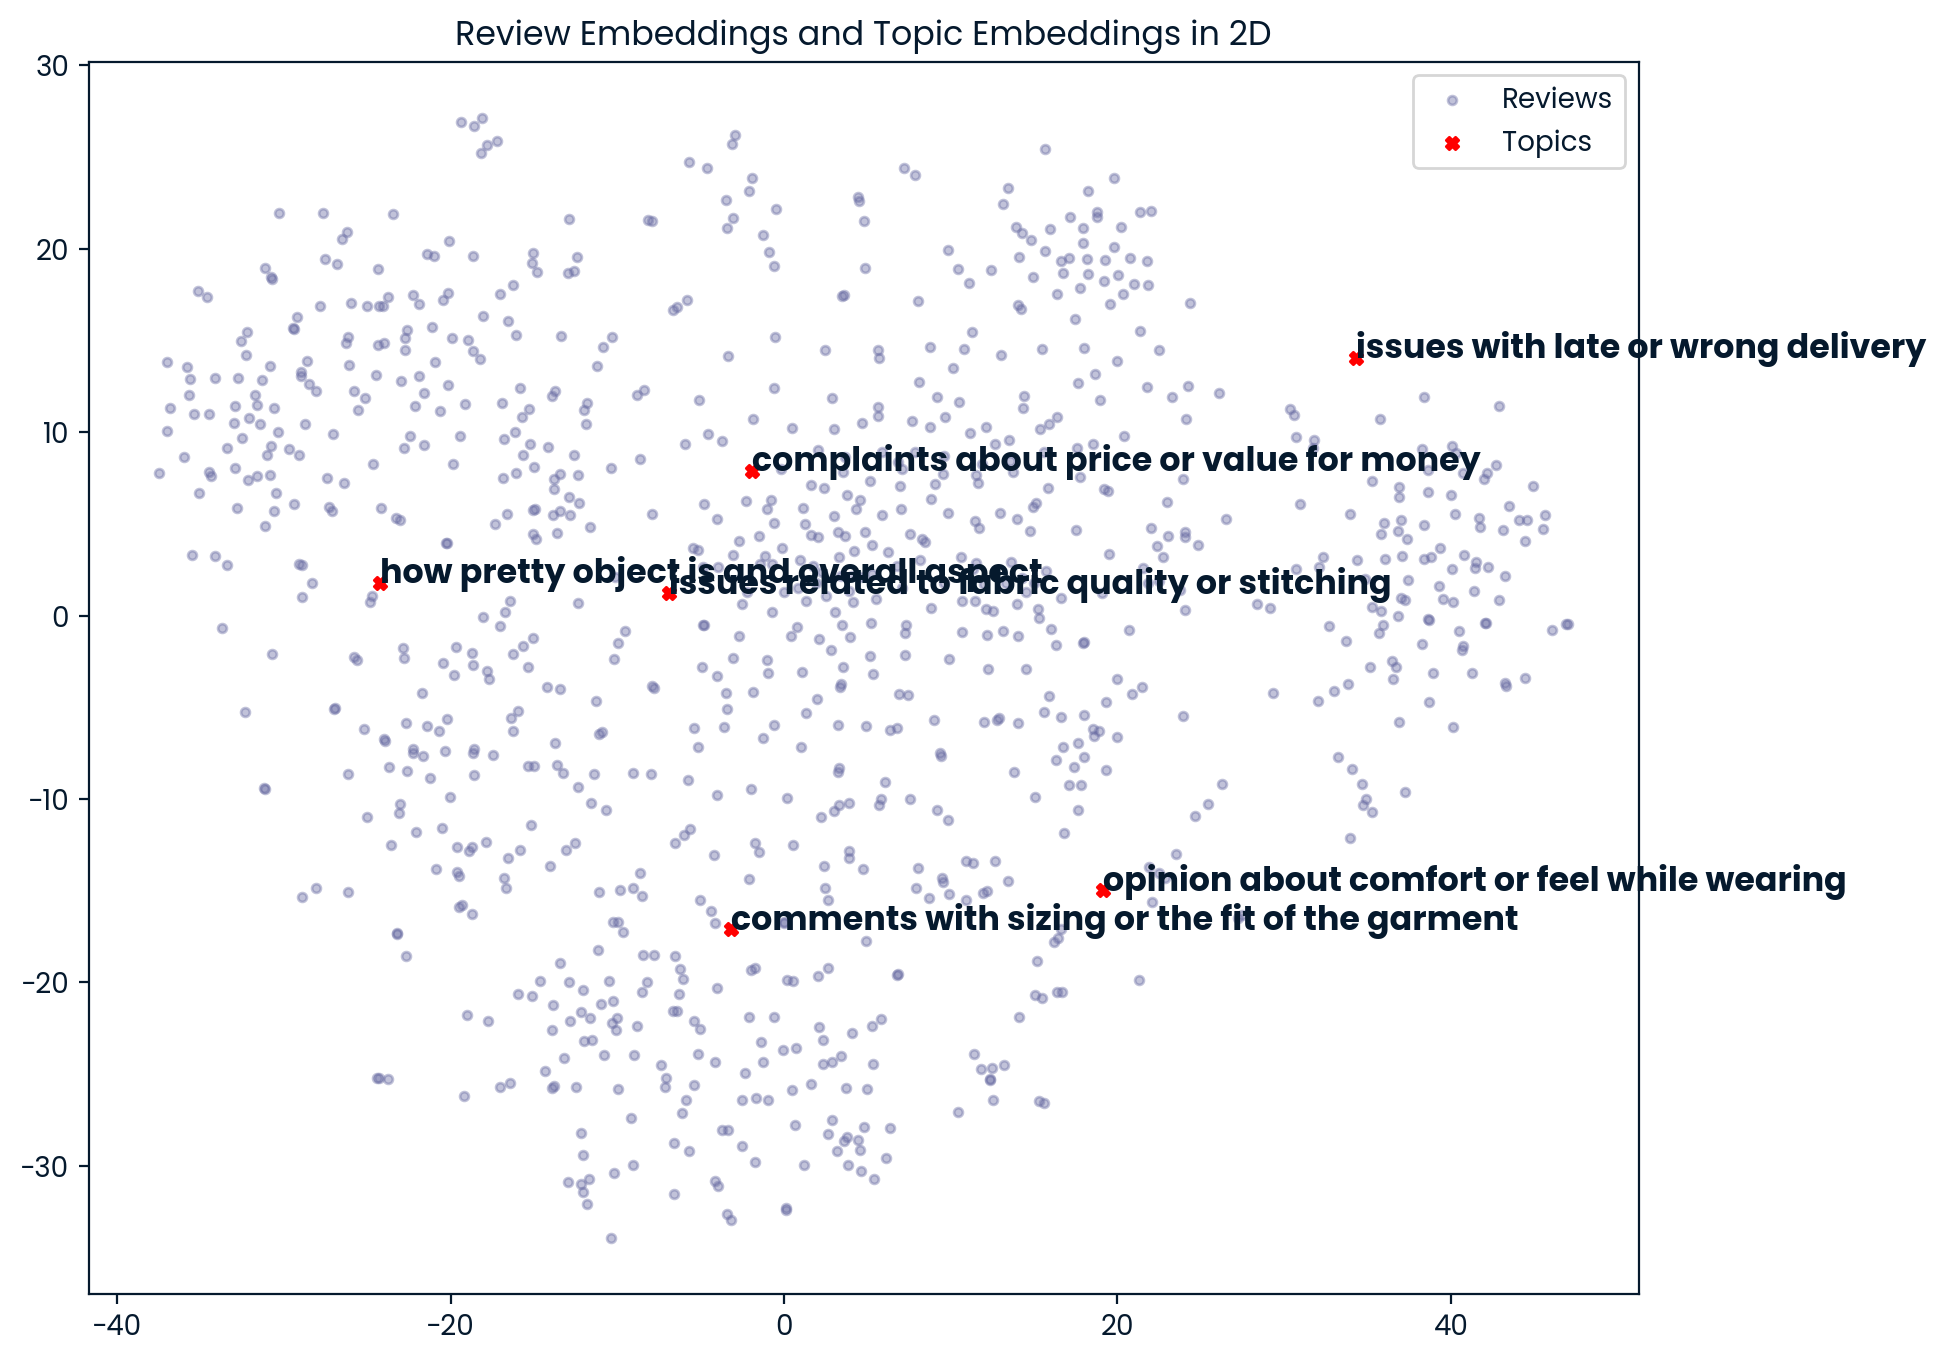

In [109]:
plt.figure(figsize=(10, 8))

# plot review embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            alpha=0.4, s=10, label="Reviews")

# plot topic points
plt.scatter(topic_embeddings_2d[:, 0], topic_embeddings_2d[:, 1],
            color="red", s=20, marker="X", label="Topics")

# annotate topics
for i, topic in enumerate(topics):
    x, y = topic_embeddings_2d[i]
    plt.text(x + 0.01, y + 0.01, topic, fontsize=12, weight="bold")

plt.title("Review Embeddings and Topic Embeddings in 2D")
plt.legend()
plt.show()

In [110]:
import chromadb

# Initialize Chroma
chroma_client = chromadb.Client()

# Get or create a collection for reviews
collection = chroma_client.create_collection(
    name="reviews",
    metadata={"hnsw:space": "cosine"},  # cosine similarity works best
    get_or_create=True  # This avoids the error if the collection already exists
)

In [111]:
collection.add(
    ids=[str(i) for i in reviews["Review ID"].tolist()],
    documents=reviews["Review Text"].tolist(),
    embeddings=embeddings
)

In [112]:
def get_similar_reviews(query_text, n_results=3):
    query_embedding = model.encode([query_text], convert_to_numpy=True).tolist()

    
    results = collection.query(
        query_embeddings=query_embedding,
        n_results=n_results
    )
    
    # Extract the review texts
    return results["documents"][0]


In [113]:
most_similar_reviews = get_similar_reviews("Absolutely wonderful - silky and sexy and comfortable")
most_similar_reviews

['Absolutely wonderful - silky and sexy and comfortable',
 'Very comfortable and versatile. got lots of compliments.',
 'Very cute, very comfortable. for me aesthetics and comfort must go hand in hand. this dress fits the bill.']